# GAM

In [1]:
%load_ext autoreload
%autoreload 2

In [23]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from pykalman import KalmanFilter

from eval import MAE, custom_metric

import numpy as np
import pandas as pd

from preprocess import data

np.random.seed(0)


import numpy as np
import pandas as pd
from pygam import LinearGAM, s, te, f


In [3]:
x_tl = data["x_timed_lagged"].reset_index(drop=True).shift(1)
x_germany = data["x_germany"].reset_index(drop=True)
x_austria = data["x_austria"].reset_index(drop=True)
y_germany = data["y_germany"][1:].reset_index(drop=True)
y_austria = data["y_austria"][1:].reset_index(drop=True)

x_germany = pd.concat([x_germany, x_tl[["GERMANY_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h]"]]], axis=1)[1:].reset_index(drop=True).drop(columns=["DATE_FROM"])
x_austria = pd.concat([x_austria, x_tl[["GERMANY_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h]"]]], axis=1)[1:].reset_index(drop=True).drop(columns=["DATE_FROM"])

In [4]:
for k, x in enumerate(x_germany.columns.tolist()):
    print(k, x)

0 tavg
1 tmin
2 tmax
3 wdir
4 wspd
5 wpgt
6 pres
7 GERMANY_BLOCK_DEMAND_[MW]
8 TOTAL_DEMAND_[MW]
9 GERMANY_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h]


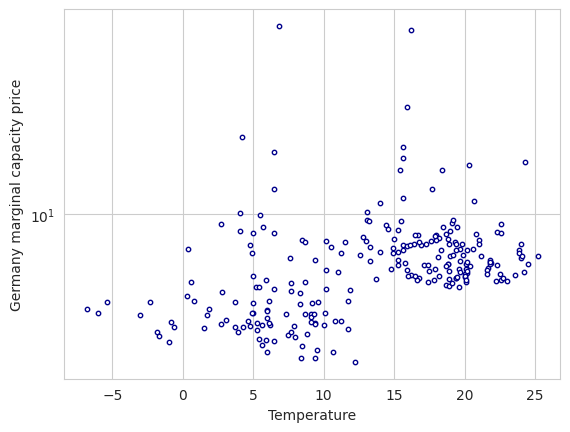

In [22]:
plt.scatter(x_germany["tavg"], y_germany, color='white', edgecolors='darkblue', s=10)
# plt.scatter(x, y, color='darkblue', edgecolor='black', s=100)
plt.title('')
plt.xlabel('Temperature')
plt.yscale('log')
plt.ylabel('Germany marginal capacity price')
plt.grid(True)
plt.savefig("tempearture_germany.png", dpi=300)
plt.show()



## GAM classiques

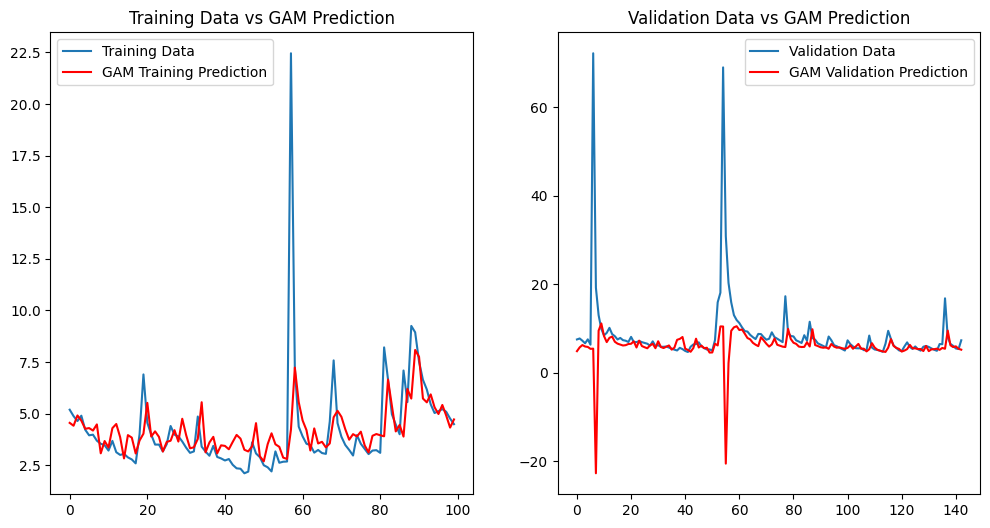

In [31]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

X, y = x_germany, y_germany

X_train = X[:100]
y_train = y[:100]


X_valid = X[100:]
y_valid = y[100:]

# Define the model with a smoothing term for the first feature
gam = LinearGAM(s(7) + s(9), )

# Fit the model on the training set
gam.fit(X_train, y_train)

# Predict using the model on both training and validation sets
y_train_pred = gam.predict(X_train)
y_valid_pred = gam.predict(X_valid)

# Plot the results
plt.figure(figsize=(12, 6))

# Plot training data and predictions
plt.subplot(1, 2, 1)
plt.plot(y_train, label='Training Data')
plt.plot(y_train_pred, color='red', label='GAM Training Prediction')
plt.title('Training Data vs GAM Prediction')
plt.legend()

# Plot validation data and predictions
plt.subplot(1, 2, 2)
plt.plot(y_valid.reset_index(drop=True), label='Validation Data')
plt.plot(y_valid_pred, color='red', label='GAM Validation Prediction')
plt.title('Validation Data vs GAM Prediction')
plt.legend()

plt.show()

=> ne marche pas car on a juste y_ger = f(X_ger) avec X_ger décalé de 1, il apprend juste un spline sur X_ger décalé de 1. Donc marche à l'entraînement mais pas à la validation.

6.1443654513778405
6.188081458901869
6.257066935517055
6.340226404241362
6.444827759716389
6.637895572748458
6.897004566851498
7.112734308753713
6.65468387976543
6.754726320124759
6.754636741091196
6.9813007797427975
7.066464319103435
7.121209929406121
7.169955657293779
7.221466318717189
7.291132438426135
7.411998985935658
7.461541190744904
7.49769396854221
7.577827098022495
7.656627786764543
7.713102514788516
7.743592763552332
7.666376298976473
7.686256947379178
7.7107549497617685
7.779810415971577
7.8349038228978625
7.912935486097851
7.971192578107948
8.060208078973032
8.12813049014792
8.158227261376005
8.404919688931024
8.468521423486186
8.509828251816941
8.545036705485286
8.386496029992978
8.328036279523086
8.405137289643047
8.429646234113068
8.483748705328242
8.551445231046866
8.6022577434235
8.719114006421755
8.756864825152325
8.789772023447103
8.810923979717641
8.834820510805343
8.871686752132579
8.900626650782934
8.995265454100169
9.014426786604659
9.092581653702933
9.167189506

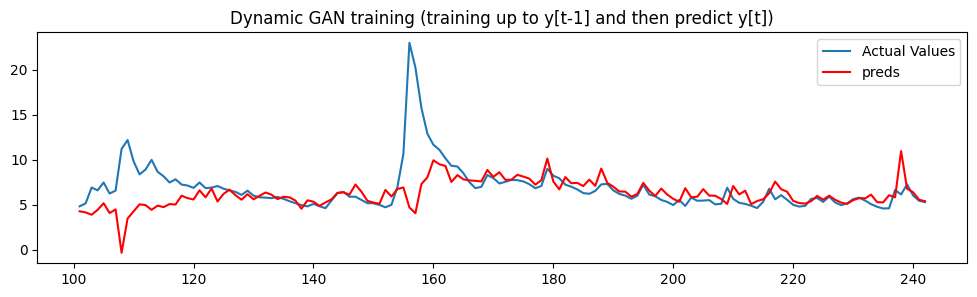

In [69]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

preds = []
ground_truth = []

X, y = x_austria, y_austria

for t in range(100, len(X) -1):
    # Define the training set
    X_train = X.iloc[:t]
    y_train = y[:t]

    gam = LinearGAM(s(9, lam=100) + te(9, 7) + s(1, lam=10) + s(7, lam=10) + te(1, 9))
    
    # Fit the model on the training set
    gam.fit(X_train, y_train)
    

    y_pred = gam.predict(X.iloc[[t]])
    edf = gam.statistics_['edof']
    print(edf)

    preds.append(y_pred[0])
    ground_truth.append(y[t])

plt.figure(figsize=(12, 3))

# Plot actual values and preds
plt.plot(range(101, len(X)), ground_truth, label='Actual Values')
plt.plot(range(101, len(X)), preds, color='red', label='preds')
plt.title('Dynamic GAN training (training up to y[t-1] and then predict y[t])')
plt.legend()

plt.show()

(1.2796901343321785, 5.149957455702293)
(1.1721168613124884, 3.435614517987246)
(1.2689852359472715, 2.3474086343574667)
(1.3756522343383415, 1.4695990901821125)


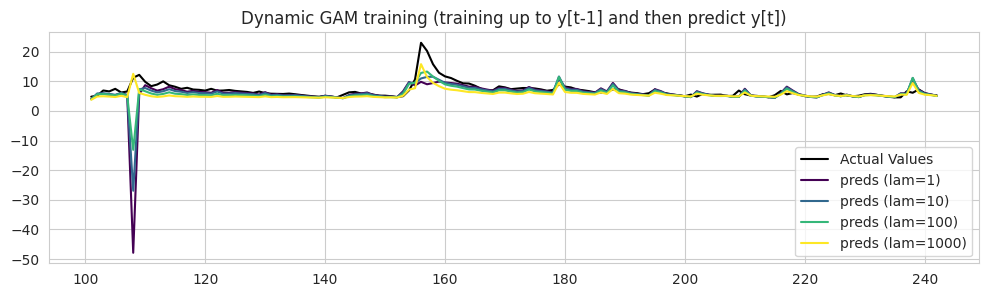

In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pygam import LinearGAM, s

preds_dict = {}
ground_truth = []

X, y = x_austria, y_austria

# Define the range of lambda values to test
lam_values = [1, 10, 100, 1000]

for lam in lam_values:
    preds = []
    for t in range(100, len(X) - 1):
        # Define the training set
        X_train = X.iloc[:t]
        y_train = y[:t]
        
        # Define the model with a smoothing term for the first feature and the current lambda value
        gam = LinearGAM(s(9, lam=lam))
        
        # Fit the model on the training set
        gam.fit(X_train, y_train)
        
        # Predict y[t+1]
        y_pred = gam.predict(X.iloc[[t]])
        
        # Store the prediction
        preds.append(y_pred[0])
    
    # Store the predictions for the current lambda value
    preds_dict[lam] = preds

    # Store the ground truth values (only need to do this once)
    if not ground_truth:
        ground_truth = y[100:len(X)-1].tolist()
    print(MAE(ground_truth, preds))

plt.figure(figsize=(12, 3))

# Plot actual values
plt.plot(range(101, len(X)), ground_truth, label='Actual Values', color='black')


cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(lam_values)))
# Plot predictions for each lambda value
for i, (lam, preds) in enumerate(preds_dict.items()):
    plt.plot(range(101, len(X)), preds, label=f'preds (lam={lam})', color=colors[i])

plt.title('Dynamic GAM training (training up to y[t-1] and then predict y[t])')
plt.legend()
plt.show()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      2.8883
Link Function:                     IdentityLink Log Likelihood:                                  -432.6191
Number of Samples:                          243 AIC:                                               873.015
                                                AICc:                                             873.1746
                                                GCV:                                                1.8371
                                                Scale:                                              1.7978
                                                Pseudo R-Squared:                                   0.7409
Feature Function                  Lam

/tmp/ipykernel_900947/1392661353.py:18: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


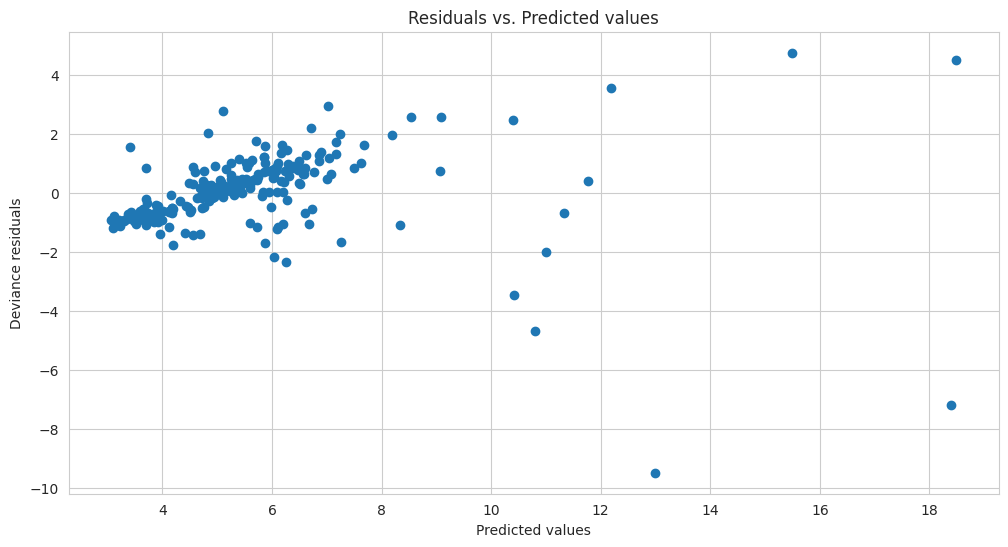

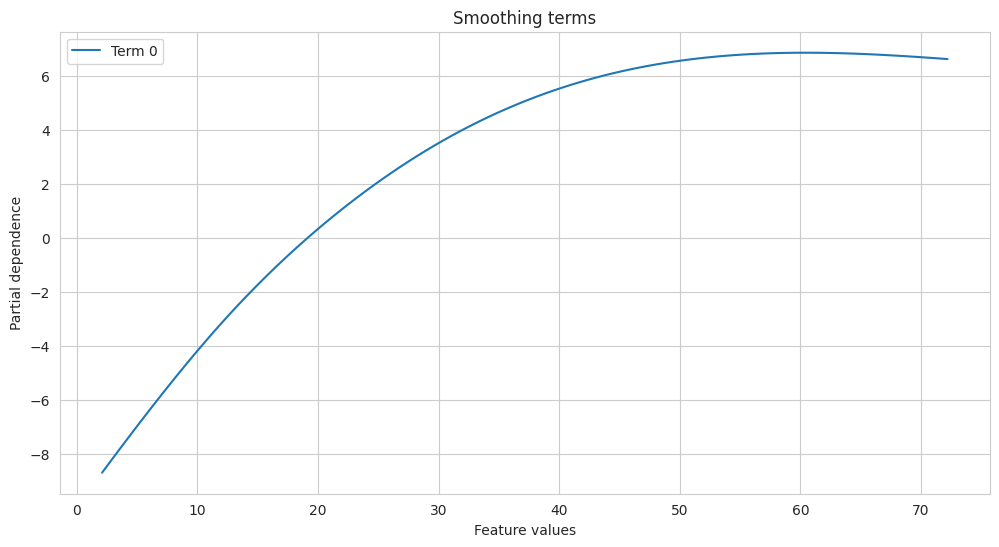

In [25]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error as MAE
import matplotlib.pyplot as plt
from pygam import LinearGAM, s

# Assuming X and y are your data
# Replace these with your actual data
X, y = x_austria, y_austria

# Define the model with a smoothing term for the first feature and a lambda value
gam = LinearGAM(s(9, lam=10, n_splines=10))  # Ensure n_splines > spline_order

# Fit the model on the entire dataset
gam.fit(X, y)

# Plot the diagnostics
gam.summary()

# Plot the residuals
plt.figure(figsize=(12, 6))
plt.scatter(gam.predict(X), gam.deviance_residuals(X, y))
plt.xlabel('Predicted values')
plt.ylabel('Deviance residuals')
plt.title('Residuals vs. Predicted values')
plt.grid(True)
plt.show()

# Plot the smoothing terms
plt.figure(figsize=(12, 6))
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    XX = gam.generate_X_grid(term=i)
    plt.plot(XX[:, term.feature], gam.partial_dependence(term=i, X=XX), label=f'Term {i}')
plt.xlabel('Feature values')
plt.ylabel('Partial dependence')
plt.title('Smoothing terms')
plt.legend()
plt.grid(True)
plt.show()

In [40]:
MAE(preds, ground_truth)

(1.1832746647346246, 2.2366054690873356)

Ici, idée : apprendre un nouveau spline à chaque étape : marche moyen car une seule valeur pour apprendre, chaque pas temporel est maintenant vu comme une feature. Toujours ce problème de décalage

## Dynamic GAM

  0% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 70% (7 of 10) |#################        | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 70% (7 of 10) |#################        | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 70% (7 of 10) |#################        | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 10) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
 70% (7 of 10) |#################        | Elapsed Time: 0:00:00 ETA:   0:00:00
100% (10 of 10) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
  0% (0 of 10) |                        

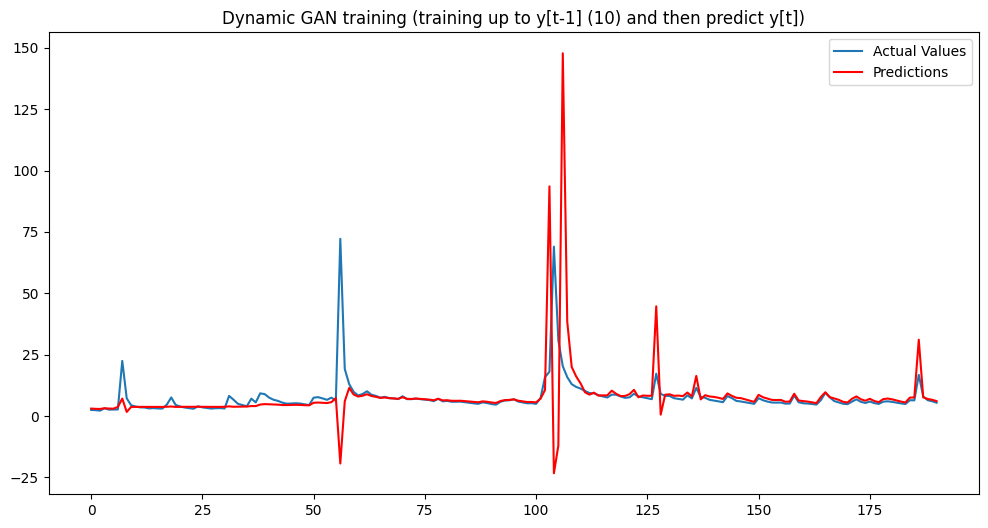

In [100]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


np.random.seed(0)


actuals = []
predictions = []
k0 = 2

# Create a new DataFrame to store the shifted columns
X_shifted = pd.DataFrame(X_ger["GERMANY_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h]"])

# Loop to create shifted columns from 1 to 10
for shift in range(k0):
    X_shifted[f'shift_{shift}'] = X_ger['GERMANY_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h]'].shift(shift)

# Drop rows with NaN values created by shifting
X_shifted = X_shifted.dropna()
y_shifted = y_ger[k0:]


for t in range(50, len(X_shifted) -1):
    # Define the training set
    X_train = X_shifted.iloc[:t]
    y_train = y_shifted[:t]

    gam = LinearGAM(s(0) + s(1, n_splines=15) + s(2, n_splines = 10))
    lam = np.logspace(-3, 3, 10)

    # Fit the model on the training set
    gam.fit(X_train, y_train)
    gam.gridsearch(X_train, y_train, lam=lam)

    y_pred = gam.predict(X_shifted.iloc[[t]])

    predictions.append(y_pred[0])
    actuals.append(y_shifted[t])
    

plt.figure(figsize=(12, 6))

# Plot actual values and predictions
plt.plot(actuals, label='Actual Values')
plt.plot(predictions, color='red', label='Predictions')
plt.title('Dynamic GAN training (training up to y[t-1] (10) and then predict y[t])')
plt.legend()

plt.show()

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error as MAE
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from pygam import LinearGAM, s

# Assuming X and y are your data
# Replace these with your actual data
X, y = x_austria, y_austria

preds_dict = {}
ground_truth = []
mae_values = []
dof_values = []

# Define the range of lambda values to test
lam_values = [1, 10, 100, 1000]

for lam in lam_values:
    preds = []
    for t in range(100, len(X) - 1):
        # Define the training set
        X_train = X.iloc[:t]
        y_train = y[:t]
        
        # Define the model with a smoothing term for the first feature and the current lambda value
        gam = LinearGAM(s(9, lam=lam) + s(7, lam=lam))  # Ensure n_splines > spline_order
        
        # Fit the model on the training set
        gam.fit(X_train, y_train)
        
        # Predict y[t+1]
        y_pred = gam.predict(X.iloc[[t]])
        
        # Store the prediction
        preds.append(y_pred[0])
    
    # Apply Kalman Filter to smooth the predictions
    kf = KalmanFilter(initial_state_mean=preds[0], n_dim_obs=1)
    state_means, _ = kf.smooth(preds)
    
    # Store the smoothed predictions for the current lambda value
    preds_dict[lam] = state_means.flatten()

    # Store the ground truth values (only need to do this once)
    if not ground_truth:
        ground_truth = y[100:len(X)-1].tolist()
    
    # Calculate and store the MAE for the current lambda value
    mae = MAE(ground_truth, state_means.flatten())
    mae_values.append(mae)
    
    # Store the degree of freedom for the parameter 9 if it exists
    edof = gam.statistics_['edof']
    dof_values.append(edof)
 # Append NaN if the index 9 does not exist

# Plot the predictions
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(range(101, len(X)), ground_truth, label='Actual Values', color='red')

# Define a colormap
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(lam_values)))

# Plot predictions for each lambda value with different colors
for i, (lam, preds) in enumerate(preds_dict.items()):
    plt.plot(range(101, len(X)), preds, label=f'preds (lam={lam})', color=colors[i])

plt.title('Dynamic GAM training with Kalman Filter (training up to y[t-1] and then predict y[t])')
plt.legend()
plt.savefig('GAM.png', dpi=300)
plt.show()

# Plot the MAE for each lambda value
plt.figure(figsize=(12, 6))
plt.plot(lam_values, mae_values, marker='o')
plt.xlabel('Lambda')
plt.ylabel('Mean Absolute Error')
plt.title('MAE vs. Lambda')
plt.xscale('log')
plt.grid(True)
plt.show()

# Plot the degree of freedom for the parameter 9
plt.figure(figsize=(12, 6))
plt.plot(lam_values, dof_values, marker='o')
plt.xlabel('Lambda')
plt.ylabel('Degree of Freedom (Parameter 9)')
plt.title('Degree of Freedom vs. Lambda')
plt.xscale('log')
plt.savefig("DOF_GAM.png", dpi=300)
plt.grid(True)
plt.show()

SyntaxError: unmatched ')' (545444065.py, line 28)

In [ ]:
from eval import MAE, custom_metric
for key, value in preds_dict.items():
    print(key)
    print(MAE(value, ground_truth))
    print(custom_metric(value, ground_truth, country="Austria"))

1
(1.1510776769129163, 2.6892048543567095)
(1153.8745316615398, 798.2060067576218)
10
(1.1113930436100636, 2.1461809910263097)
(1160.5632865413115, 728.8677733128246)
100
(1.161054695853706, 1.7807044596064043)
(1135.0922460373054, 698.1294700391047)
1000
(1.2405604939153922, 1.449187290329265)
(1071.7941226265966, 681.107648927403)


Lambda: 1, MAE: 1.2796901343321785
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      5.9287
Link Function:                     IdentityLink Log Likelihood:                                  -356.2933
Number of Samples:                          241 AIC:                                               726.444
                                                AICc:                                             726.9154
                                                GCV:                                                 1.194
                                                Scale:                                              1.1412
                                                Pseudo R-Squared:                                    0.839
Fe

/tmp/ipykernel_900947/2891299141.py:43: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


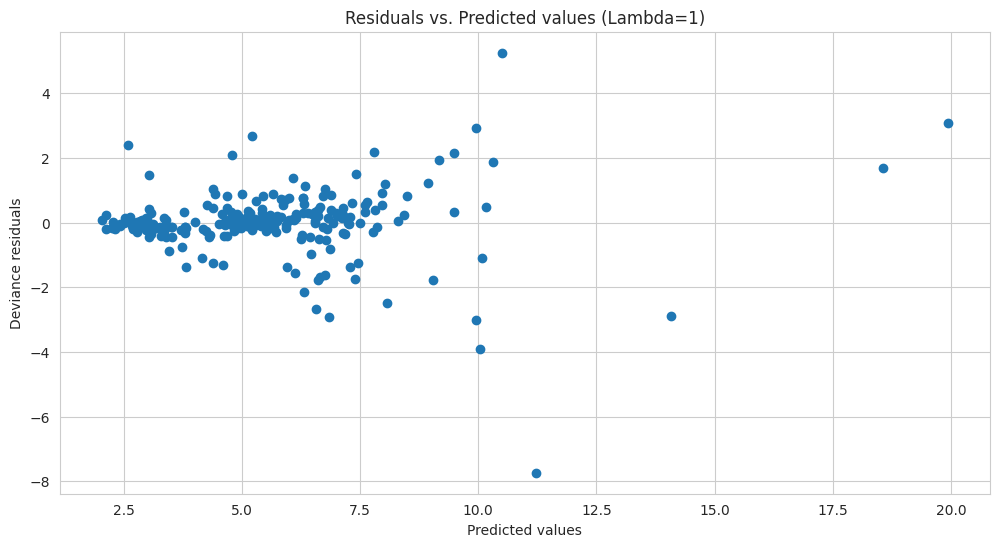

Lambda: 10, MAE: 1.1721168613124884
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                       4.194
Link Function:                     IdentityLink Log Likelihood:                                   -393.276
Number of Samples:                          241 AIC:                                                796.94
                                                AICc:                                              797.214
                                                GCV:                                                1.5025
                                                Scale:                                              1.4555
                                                Pseudo R-Squared:                                   0.7931
F

/tmp/ipykernel_900947/2891299141.py:43: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


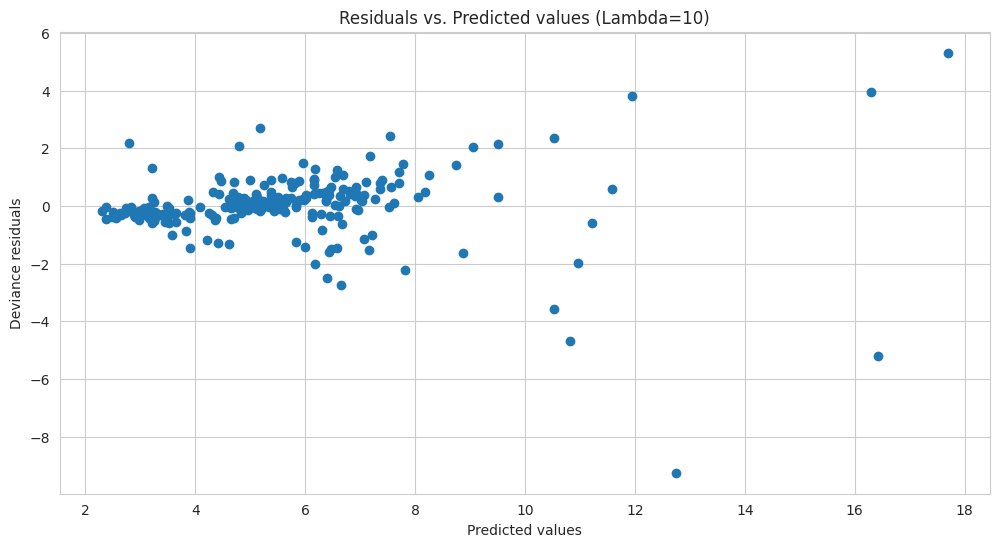

Lambda: 100, MAE: 1.2689852359472715
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      3.0815
Link Function:                     IdentityLink Log Likelihood:                                  -422.4463
Number of Samples:                          241 AIC:                                              853.0556
                                                AICc:                                             853.2314
                                                GCV:                                                 1.772
                                                Scale:                                              1.7312
                                                Pseudo R-Squared:                                   0.7528


/tmp/ipykernel_900947/2891299141.py:43: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


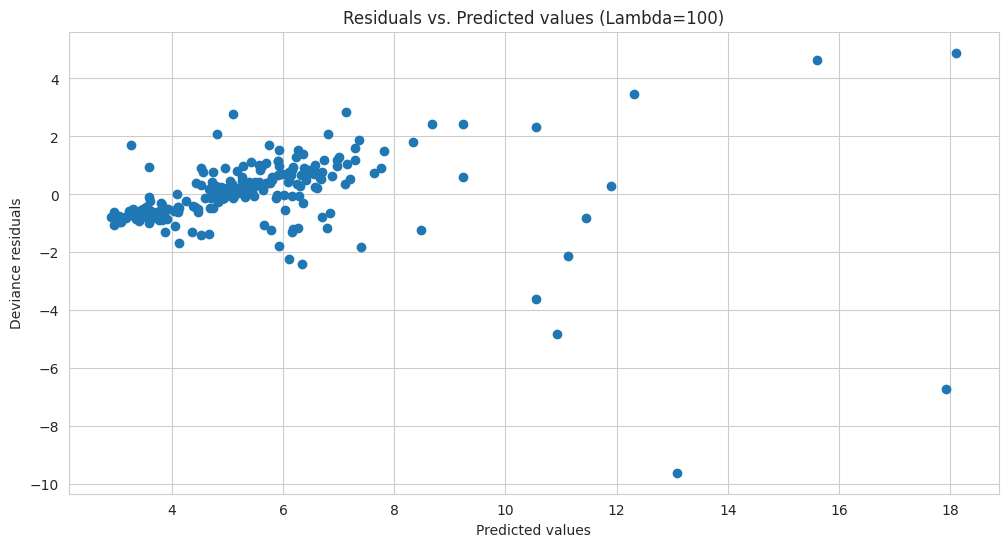

Lambda: 1000, MAE: 1.3756522343383415
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      2.3363
Link Function:                     IdentityLink Log Likelihood:                                   -488.477
Number of Samples:                          241 AIC:                                              983.6265
                                                AICc:                                             983.7487
                                                GCV:                                                2.5241
                                                Scale:                                              2.4801
                                                Pseudo R-Squared:                                   0.6447

/tmp/ipykernel_900947/2891299141.py:43: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


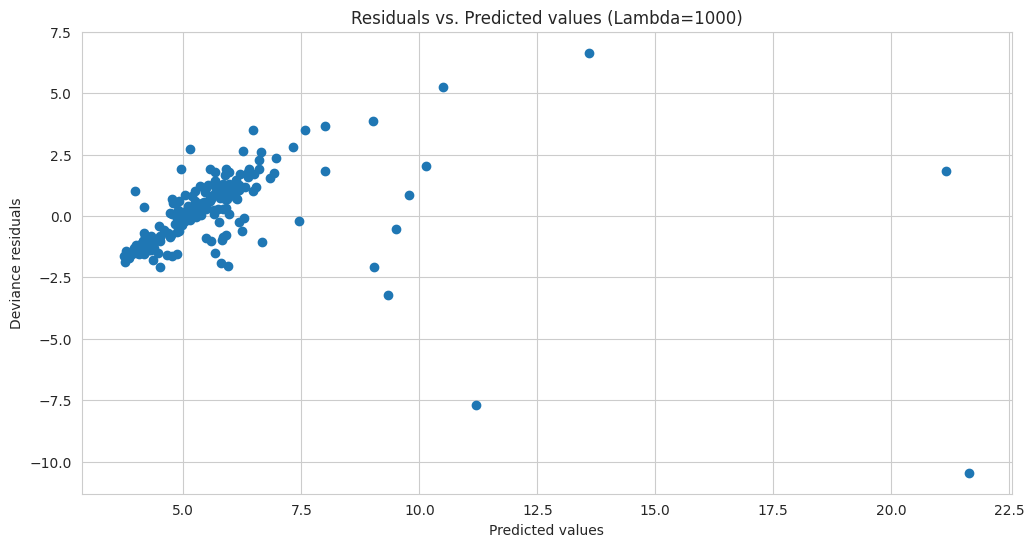

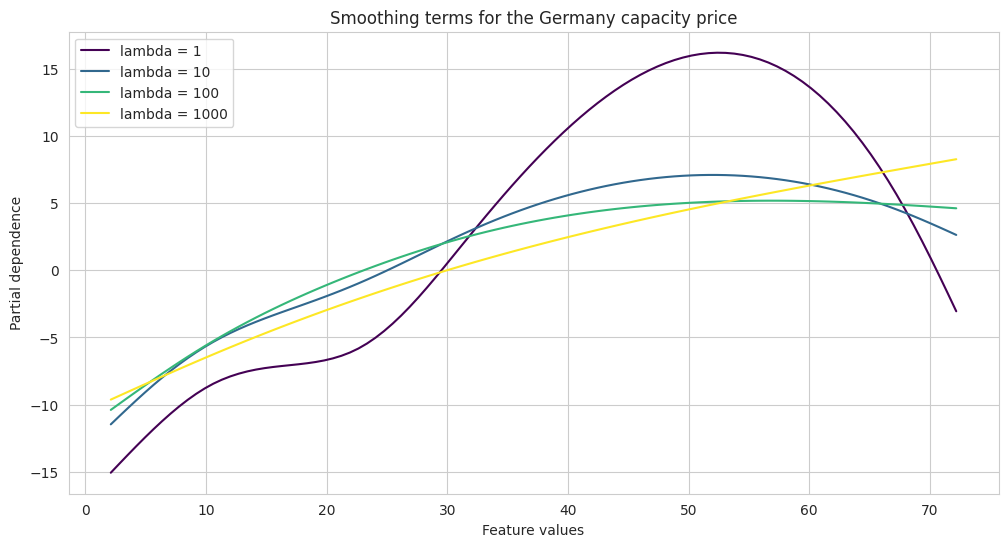

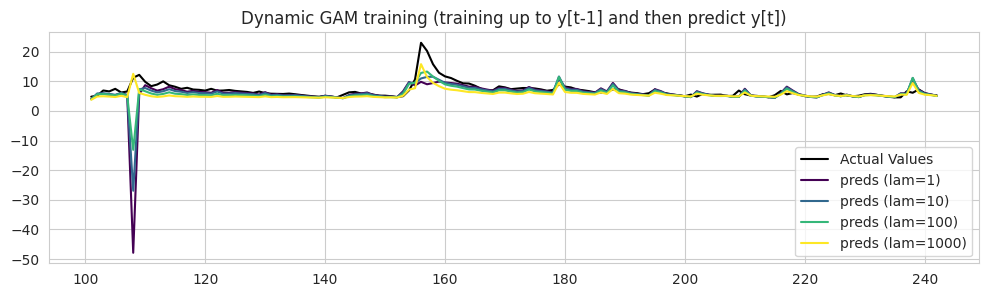

In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pygam import LinearGAM, s
from sklearn.metrics import mean_absolute_error as MAE
import numpy as np

preds_dict = {}
ground_truth = []

X, y = x_germany, y_germany

# Define the range of lambda values to test
lam_values = [1, 10, 100, 1000]
gams = []
for lam in lam_values:
    preds = []
    for t in range(100, len(X) - 1):
        # Define the training set
        X_train = X.iloc[:t]
        y_train = y[:t]
        
        # Define the model with a smoothing term for the first feature and the current lambda value
        gam = LinearGAM(s(9, lam=lam))
        
        # Fit the model on the training set
        gam.fit(X_train, y_train)
        
        # Predict y[t+1]
        y_pred = gam.predict(X.iloc[[t]])
        
        # Store the prediction
        preds.append(y_pred[0])
    
    # Store the predictions for the current lambda value
    preds_dict[lam] = preds

    # Store the ground truth values (only need to do this once)
    if not ground_truth:
        ground_truth = y[100:len(X)-1].tolist()
    print(f'Lambda: {lam}, MAE: {MAE(ground_truth, preds)}')

    # Plot the diagnostics for the current lambda value
    gam.summary()
    gams.append(gam)

    # Plot the residuals
    plt.figure(figsize=(12, 6))
    plt.scatter(gam.predict(X), gam.deviance_residuals(X, y))
    plt.xlabel('Predicted values')
    plt.ylabel('Deviance residuals')
    plt.title(f'Residuals vs. Predicted values (Lambda={lam})')
    plt.grid(True)
    plt.show()

    # Plot all the smoothing terms on the same graph
plt.figure(figsize=(12, 6))
colors = cmap(np.linspace(0, 1, len(lam_values)))
for j, gam in enumerate(gams):
    for i, term in enumerate(gam.terms):
        if term.isintercept:
            continue
        XX = gam.generate_X_grid(term=i)
        plt.plot(XX[:, term.feature], gam.partial_dependence(term=i, X=XX), label=f'lambda = {lam_values[j]}', color=colors[j])
plt.xlabel('Feature values')
plt.ylabel('Partial dependence')
plt.title(f'Smoothing terms for the Germany capacity price')
plt.legend()
plt.grid(True)
plt.savefig("gam_partial_dependence.png", dpi=300)
plt.show()

plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(range(101, len(X)), ground_truth, label='Actual Values', color='red')

cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, len(lam_values)))
# Plot predictions for each lambda value
for i, (lam, preds) in enumerate(preds_dict.items()):
    plt.plot(range(101, len(X)), preds, label=f'preds (lam={lam})', color=colors[i])

plt.title('Dynamic GAM training (training up to y[t-1] and then predict y[t])')
plt.savefig("gam_germany.png", dpi=300)
plt.legend()
plt.show()